In [0]:
import numpy
import matplotlib.pyplot as plt
import pandas
import math
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
from torch.autograd import Variable
import torch
import numpy as np
from torch import nn
from torch import optim
import torch.nn.functional as F
from keras.layers import LSTM

In [38]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [0]:

DRIVE_DIR = '/content/drive/My Drive/Deep/flight_data (1).csv'

In [0]:
class Encoder(nn.Module):
    """encoder in DA_RNN."""

    def __init__(self, T,
                 input_size,
                 encoder_num_hidden,
                 parallel=False):
        """Initialize an encoder in DA_RNN."""
        super(Encoder, self).__init__()
        self.encoder_num_hidden = encoder_num_hidden
        self.input_size = input_size
        self.parallel = parallel
        self.T = T

        # Fig 1. Temporal Attention Mechanism: Encoder is LSTM
        self.encoder_lstm = nn.LSTM(
            input_size=self.input_size,
            hidden_size=self.encoder_num_hidden,
            num_layers = 1
        )

        # Construct Input Attention Mechanism via deterministic attention model
        # Eq. 8: W_e[h_{t-1}; s_{t-1}] + U_e * x^k
        self.encoder_attn = nn.Linear(
            in_features=2 * self.encoder_num_hidden + self.T - 1,
            out_features=1
        )

    def forward(self, X):
        """forward.

        Args:
            X: input data

        """
        X_tilde = Variable(X.data.new(
            X.size(0), self.T - 1, self.input_size).zero_())
        X_encoded = Variable(X.data.new(
            X.size(0), self.T - 1, self.encoder_num_hidden).zero_())

        # Eq. 8, parameters not in nn.Linear but to be learnt
        # v_e = torch.nn.Parameter(data=torch.empty(
        #     self.input_size, self.T).uniform_(0, 1), requires_grad=True)
        # U_e = torch.nn.Parameter(data=torch.empty(
        #     self.T, self.T).uniform_(0, 1), requires_grad=True)

        # h_n, s_n: initial states with dimention hidden_size
        h_n = self._init_states(X)
        s_n = self._init_states(X)

        for t in range(self.T - 1):
            # batch_size * input_size * (2 * hidden_size + T - 1)
            x = torch.cat((h_n.repeat(self.input_size, 1, 1).permute(1, 0, 2),
                           s_n.repeat(self.input_size, 1, 1).permute(1, 0, 2),
                           X.permute(0, 2, 1)), dim=2)

            x = self.encoder_attn(
                x.view(-1, self.encoder_num_hidden * 2 + self.T - 1))

            # get weights by softmax
            alpha = F.softmax(x.view(-1, self.input_size))

            # get new input for LSTM
            x_tilde = torch.mul(alpha, X[:, t, :])

            # Fix the warning about non-contiguous memory
            # https://discuss.pytorch.org/t/dataparallel-issue-with-flatten-parameter/8282
            self.encoder_lstm.flatten_parameters()

            # encoder LSTM
            _, final_state = self.encoder_lstm(x_tilde.unsqueeze(0), (h_n, s_n))
            h_n = final_state[0]
            s_n = final_state[1]

            X_tilde[:, t, :] = x_tilde
            X_encoded[:, t, :] = h_n

        return X_tilde, X_encoded

    def _init_states(self, X):
        """Initialize all 0 hidden states and cell states for encoder.

        Args:
            X

        Returns:
            initial_hidden_states
        """
        # https://pytorch.org/docs/master/nn.html?#lstm
        return Variable(X.data.new(1, X.size(0), self.encoder_num_hidden).zero_())

from keras.layers import LSTM as DARNN








class Decoder(nn.Module):
    """decoder in DA_RNN."""

    def __init__(self, T, decoder_num_hidden, encoder_num_hidden):
        """Initialize a decoder in DA_RNN."""
        super(Decoder, self).__init__()
        self.decoder_num_hidden = decoder_num_hidden
        self.encoder_num_hidden = encoder_num_hidden
        self.T = T

        self.attn_layer = nn.Sequential(
            nn.Linear(2 * decoder_num_hidden + encoder_num_hidden, encoder_num_hidden),
            nn.Tanh(),
            nn.Linear(encoder_num_hidden, 1)
        )
        self.lstm_layer = nn.LSTM(
            input_size=1,
            hidden_size=decoder_num_hidden
        )
        self.fc = nn.Linear(encoder_num_hidden + 1, 1)
        self.fc_final = nn.Linear(decoder_num_hidden + encoder_num_hidden, 1)

        self.fc.weight.data.normal_()

    def forward(self, X_encoded, y_prev):
        """forward."""
        d_n = self._init_states(X_encoded)
        c_n = self._init_states(X_encoded)

        for t in range(self.T - 1):

            x = torch.cat((d_n.repeat(self.T - 1, 1, 1).permute(1, 0, 2),
                           c_n.repeat(self.T - 1, 1, 1).permute(1, 0, 2),
                           X_encoded), dim=2)

            beta = F.softmax(self.attn_layer(
                x.view(-1, 2 * self.decoder_num_hidden + self.encoder_num_hidden)).view(-1, self.T - 1))

            # Eqn. 14: compute context vector
            # batch_size * encoder_hidden_size
            context = torch.bmm(beta.unsqueeze(1), X_encoded)[:, 0, :]
            if t < self.T - 1:
                # Eqn. 15
                # batch_size * 1
                y_tilde = self.fc(
                    torch.cat((context, y_prev[:, t].unsqueeze(1)), dim=1))

                # Eqn. 16: LSTM
                self.lstm_layer.flatten_parameters()
                _, final_states = self.lstm_layer(
                    y_tilde.unsqueeze(0), (d_n, c_n))

                d_n = final_states[0]  # 1 * batch_size * decoder_num_hidden
                c_n = final_states[1]  # 1 * batch_size * decoder_num_hidden

        # Eqn. 22: final output
        y_pred = self.fc_final(torch.cat((d_n[0], context), dim=1))

        return y_pred

    def _init_states(self, X):
        """Initialize all 0 hidden states and cell states for encoder.

        Args:
            X
        Returns:
            initial_hidden_states

        """
        # hidden state and cell state [num_layers*num_directions, batch_size, hidden_size]
        # https://pytorch.org/docs/master/nn.html?#lstm
        return Variable(X.data.new(1, X.size(0), self.decoder_num_hidden).zero_())


class DA_rnn(nn.Module):
    """da_rnn."""

    def __init__(self, X, y, T,
                 encoder_num_hidden,
                 decoder_num_hidden,
                 batch_size,
                 learning_rate,
                 epochs,
                 parallel=False):
        """da_rnn initialization."""
        super(DA_rnn, self).__init__()
        self.encoder_num_hidden = encoder_num_hidden
        self.decoder_num_hidden = decoder_num_hidden
        self.learning_rate = learning_rate
        self.batch_size = batch_size
        self.parallel = parallel
        self.shuffle = False
        self.epochs = epochs
        self.T = T
        self.X = X
        self.y = y

        self.device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
        print("==> Use accelerator: ", self.device)

        self.Encoder = Encoder(input_size=X.shape[1],
                               encoder_num_hidden=encoder_num_hidden,
                               T=T).to(self.device)
        self.Decoder = Decoder(encoder_num_hidden=encoder_num_hidden,
                               decoder_num_hidden=decoder_num_hidden,
                               T=T).to(self.device)

        # Loss function
        self.criterion = nn.MSELoss()

        if self.parallel:
            self.encoder = nn.DataParallel(self.encoder)
            self.decoder = nn.DataParallel(self.decoder)

        self.encoder_optimizer = optim.Adam(params=filter(lambda p: p.requires_grad,
                                                          self.Encoder.parameters()),
                                            lr=self.learning_rate)
        self.decoder_optimizer = optim.Adam(params=filter(lambda p: p.requires_grad,
                                                          self.Decoder.parameters()),
                                            lr=self.learning_rate)

        # Training set
        self.train_timesteps = int(self.X.shape[0] * 0.7)
        self.y = self.y - np.mean(self.y[:self.train_timesteps])
        self.input_size = self.X.shape[1]

    def train(self):
        """training process."""
        iter_per_epoch = int(np.ceil(self.train_timesteps * 1. / self.batch_size))
        self.iter_losses = np.zeros(self.epochs * iter_per_epoch)
        self.epoch_losses = np.zeros(self.epochs)

        n_iter = 0

        for epoch in range(self.epochs):
            if self.shuffle:
                ref_idx = np.random.permutation(self.train_timesteps - self.T)
            else:
                ref_idx = np.array(range(self.train_timesteps - self.T))

            idx = 0

            while (idx < self.train_timesteps):
                # get the indices of X_train
                indices = ref_idx[idx:(idx + self.batch_size)]
                # x = np.zeros((self.T - 1, len(indices), self.input_size))
                x = np.zeros((len(indices), self.T - 1, self.input_size))
                y_prev = np.zeros((len(indices), self.T - 1))
                y_gt = self.y[indices + self.T]

                # format x into 3D tensor
                for bs in range(len(indices)):
                    x[bs, :, :] = self.X[indices[bs]:(indices[bs] + self.T - 1), :]
                    y_prev[bs, :] = self.y[indices[bs]: (indices[bs] + self.T - 1)]

                loss = self.train_forward(x, y_prev, y_gt)
                self.iter_losses[int(epoch * iter_per_epoch + idx / self.batch_size)] = loss

                idx += self.batch_size
                n_iter += 1

                if n_iter % 10000 == 0 and n_iter != 0:
                    for param_group in self.encoder_optimizer.param_groups:
                        param_group['lr'] = param_group['lr'] * 0.9
                    for param_group in self.decoder_optimizer.param_groups:
                        param_group['lr'] = param_group['lr'] * 0.9

                self.epoch_losses[epoch] = np.mean(self.iter_losses[range(
                    epoch * iter_per_epoch, (epoch + 1) * iter_per_epoch)])

            if epoch % 10 == 0:
                print("Epochs: ", epoch, " Iterations: ", n_iter,
                      " Loss: ", self.epoch_losses[epoch])

            if epoch % 10 == 0:
                y_train_pred = self.test(on_train=True)
                y_test_pred = self.test(on_train=False)
                y_pred = np.concatenate((y_train_pred, y_test_pred))
                plt.ioff()
                plt.figure()
                plt.plot(range(1, 1 + len(self.y)), self.y, label="True")
                plt.plot(range(self.T, len(y_train_pred) + self.T),
                         y_train_pred, label='Predicted - Train')
                plt.plot(range(self.T + len(y_train_pred), len(self.y) + 1),
                         y_test_pred, label='Predicted - Test')
                plt.legend(loc='upper left')
                plt.show()

            # # Save files in last iterations
            # if epoch == self.epochs - 1:
            #     np.savetxt('../loss.txt', np.array(self.epoch_losses), delimiter=',')
            #     np.savetxt('../y_pred.txt',
            #                np.array(self.y_pred), delimiter=',')
            #     np.savetxt('../y_true.txt',
            #                np.array(self.y_true), delimiter=',')

    def train_forward(self, X, y_prev, y_gt):
        """
        Forward pass.

        Args:
            X:
            y_prev:
            y_gt: Ground truth label

        """
        # zero gradients
        self.encoder_optimizer.zero_grad()
        self.decoder_optimizer.zero_grad()

        input_weighted, input_encoded = self.Encoder(
            Variable(torch.from_numpy(X).type(torch.FloatTensor).to(self.device)))
        y_pred = self.Decoder(input_encoded, Variable(
            torch.from_numpy(y_prev).type(torch.FloatTensor).to(self.device)))

        y_true = Variable(torch.from_numpy(
            y_gt).type(torch.FloatTensor).to(self.device))

        y_true = y_true.view(-1, 1)
        loss = self.criterion(y_pred, y_true)
        loss.backward()

        self.encoder_optimizer.step()
        self.decoder_optimizer.step()

        return loss.item()


    def test(self, on_train=False):
        """test."""

        if on_train:
            y_pred = np.zeros(self.train_timesteps - self.T + 1)
        else:
            y_pred = np.zeros(self.X.shape[0] - self.train_timesteps)

        i = 0
        while i < len(y_pred):
            batch_idx = np.array(range(len(y_pred)))[i: (i + self.batch_size)]
            X = np.zeros((len(batch_idx), self.T - 1, self.X.shape[1]))
            y_history = np.zeros((len(batch_idx), self.T - 1))

            for j in range(len(batch_idx)):
                if on_train:
                    X[j, :, :] = self.X[range(
                        batch_idx[j], batch_idx[j] + self.T - 1), :]
                    y_history[j, :] = self.y[range(
                        batch_idx[j], batch_idx[j] + self.T - 1)]
                else:
                    X[j, :, :] = self.X[range(
                        batch_idx[j] + self.train_timesteps - self.T, batch_idx[j] + self.train_timesteps - 1), :]
                    y_history[j, :] = self.y[range(
                        batch_idx[j] + self.train_timesteps - self.T, batch_idx[j] + self.train_timesteps - 1)]

            y_history = Variable(torch.from_numpy(
                y_history).type(torch.FloatTensor).to(self.device))
            _, input_encoded = self.Encoder(
                Variable(torch.from_numpy(X).type(torch.FloatTensor).to(self.device)))
            y_pred[i:(i + self.batch_size)] = self.Decoder(input_encoded,
                                                           y_history).cpu().data.numpy()[:, 0]
            i += self.batch_size

        return y_pred

import numpy as np
import pandas as pd


def read_data(input_path, debug=True):
    """Read nasdaq stocks data.

    Args:
        input_path (str): directory to nasdaq dataset.

    Returns:
        X (np.ndarray): features.
        y (np.ndarray): ground truth.

    """
    df = pd.read_csv(input_path, nrows=250 if debug else None)
    # X = df.iloc[:, 0:-1].values
    X = df.loc[:, [x for x in df.columns.tolist() if x != 'NDX']].as_matrix()
    # y = df.iloc[:, -1].values
    y = np.array(df.NDX)

    return X, y

In [0]:
numpy.random.seed(7)

In [60]:
import locale
import numpy as np
locale.setlocale(locale.LC_ALL, 'en_US.UTF8')

'en_US.UTF8'

In [0]:
dataframe = pandas.read_csv(DRIVE_DIR, usecols=[1], engine='python')
dataset = dataframe.values
#dataset = dataset.astype('float32')

In [0]:
X= []
for x in dataset:
  X.append([int(x[0].replace(',',''))])
dataset =np.array(X)

In [0]:
scaler = MinMaxScaler(feature_range=(0, 1))
dataset = scaler.fit_transform(dataset)

In [64]:
train_size = int(len(dataset) * 0.67)
test_size = len(dataset) - train_size
train, test = dataset[0:train_size,:], dataset[train_size:len(dataset),:]
print(len(train), len(test))

136 67


In [0]:
# convert an array of values into a dataset matrix
def create_dataset(dataset, look_back=1):
	dataX, dataY = [], []
	for i in range(len(dataset)-look_back-1):
		a = dataset[i:(i+look_back), 0]
		dataX.append(a)
		dataY.append(dataset[i + look_back, 0])
	return numpy.array(dataX), numpy.array(dataY)

In [0]:
# reshape into X=t and Y=t+1
look_back = 1
trainX, trainY = create_dataset(train, look_back)
testX, testY = create_dataset(test, look_back)

In [0]:
# reshape input to be [samples, time steps, features]
trainX = numpy.reshape(trainX, (trainX.shape[0], 1, trainX.shape[1]))
testX = numpy.reshape(testX, (testX.shape[0], 1, testX.shape[1]))

In [68]:
# create and fit the LSTM network
model = Sequential()
model.add(DARNN(4, input_shape=(1, look_back)))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='rmsprop')
model.fit(trainX, trainY, epochs=500, batch_size=1, verbose=2)

Epoch 1/500
 - 1s - loss: 0.0642
Epoch 2/500
 - 0s - loss: 0.0186
Epoch 3/500
 - 0s - loss: 0.0138
Epoch 4/500
 - 0s - loss: 0.0136
Epoch 5/500
 - 0s - loss: 0.0134
Epoch 6/500
 - 0s - loss: 0.0133
Epoch 7/500
 - 0s - loss: 0.0131
Epoch 8/500
 - 0s - loss: 0.0130
Epoch 9/500
 - 0s - loss: 0.0128
Epoch 10/500
 - 0s - loss: 0.0127
Epoch 11/500
 - 0s - loss: 0.0126
Epoch 12/500
 - 0s - loss: 0.0125
Epoch 13/500
 - 0s - loss: 0.0124
Epoch 14/500
 - 0s - loss: 0.0123
Epoch 15/500
 - 0s - loss: 0.0122
Epoch 16/500
 - 0s - loss: 0.0122
Epoch 17/500
 - 0s - loss: 0.0121
Epoch 18/500
 - 0s - loss: 0.0121
Epoch 19/500
 - 0s - loss: 0.0120
Epoch 20/500
 - 0s - loss: 0.0119
Epoch 21/500
 - 0s - loss: 0.0119
Epoch 22/500
 - 0s - loss: 0.0119
Epoch 23/500
 - 0s - loss: 0.0118
Epoch 24/500
 - 0s - loss: 0.0115
Epoch 25/500
 - 0s - loss: 0.0118
Epoch 26/500
 - 0s - loss: 0.0117
Epoch 27/500
 - 0s - loss: 0.0117
Epoch 28/500
 - 0s - loss: 0.0116
Epoch 29/500
 - 0s - loss: 0.0117
Epoch 30/500
 - 0s - lo

In [69]:
# make predictions
trainPredict = model.predict(trainX)
testPredict = model.predict(testX)
# invert predictions
trainPredict = scaler.inverse_transform(trainPredict)
trainY = scaler.inverse_transform([trainY])
testPredict = scaler.inverse_transform(testPredict)
testY = scaler.inverse_transform([testY])
# calculate root mean squared error
trainScore = math.sqrt(mean_squared_error(trainY[0], trainPredict[:,0]))
b=50000
print('Train Score: %.2f RMSE' % (trainScore/b))
testScore = math.sqrt(mean_squared_error(testY[0], testPredict[:,0]))
print('Test Score: %.2f RMSE' % (testScore/b))

Train Score: 105.35 RMSE
Test Score: 151.48 RMSE


In [74]:
print('Train Score: %.2f RMSE' % (trainScore/(b*10)))
testScore = math.sqrt(mean_squared_error(testY[0], testPredict[:,0]))
print('Test Score: %.2f RMSE' % (testScore/(b*10)))

Train Score: 10.54 RMSE
Test Score: 15.15 RMSE


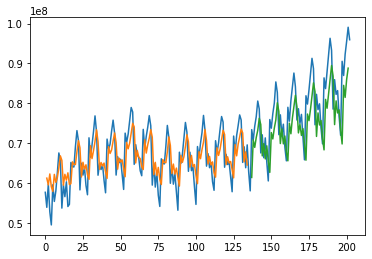

In [73]:
# shift train predictions for plotting
trainPredictPlot = numpy.empty_like(dataset)
trainPredictPlot[:, :] = numpy.nan
trainPredictPlot[look_back:len(trainPredict)+look_back, :] = trainPredict
# shift test predictions for plotting
testPredictPlot = numpy.empty_like(dataset)
testPredictPlot[:, :] = numpy.nan
testPredictPlot[len(trainPredict)+(look_back*2)+1:len(dataset)-1, :] = testPredict
# plot baseline and predictions
plt.plot(scaler.inverse_transform(dataset))
plt.plot(trainPredictPlot)
plt.plot(testPredictPlot)
plt.show()